In [14]:
import numpy as np
import random

class TrafficSimulation():
    
    def __init__(self, road_length, traffic_density, max_velocity, slowdown_proba):
        
        assert type(max_velocity) is int, "Max_velocity must be an integer!"
        self.max_velocity = max_velocity
        
        assert type(road_length) is int, "Road length must be an integer!"
        self.road_length = road_length
        
        assert traffic_density >= 0 and traffic_density <=1, "Traffic density must be a proportion, 0<=x<=1"
        self.traffic_density = traffic_density
        
        assert slowdown_proba >= 0 and slowdown_proba <=1, "slowdown_proba must be a probability, 0<=x<=1"
        self.slowdown_proba = slowdown_proba
        
        #Track number of cars that have passed the boundary
        self.flow = 0
        
        #Track number of timestep the simulation has been run
        self.time = 0
        
        
        #Make road
        #Infer number of cars
        self.num_cars = np.round(road_length*traffic_density)
        num_cars = np.round(road_length*traffic_density)
        road_array = np.full(road_length, -1)
        
        car_counter = 0
        #Insert the cars with 0 velocity at random positions on the road
        while car_counter < num_cars:
            random_loc = random.randrange(0, road_length)
            if road_array[random_loc] == -1:
                road_array[random_loc] = 0
                car_counter += 1
                
        self.road = road_array
    
    
    def update_velocities(self):
        '''
        Updates velocity of each of the cars on the road
        '''
        #Make a copy to store updates on
        #next_state = self.road
        
        #Find the road location of all cars
        car_positions = np.where(self.road != -1)[0]
        #Initialize previous car
        previous_car = car_positions[-1]
        
        for car_pos in car_positions:
            
            #Accelerate car by 1, if not already at max speed
            if self.road[previous_car] < self.max_velocity:
                self.road[previous_car] += 1
            
            #Account for periodic boundary condition using mod road length
            distance = (car_pos - previous_car) % self.road_length
            
            #self.road[car_pos] is current velocity of car
            current_velocity = self.road[previous_car]
            
            #Slow down due to other cars?
            if distance <= current_velocity and current_velocity > 0:
                self.road[previous_car] = distance - 1

            #Random slowdown?
            if random.random() <= self.slowdown_proba and current_velocity > 0:
                #print("Car randomly slowed")
                self.road[previous_car] -= 1
            
            #Make current car previous car
            previous_car = car_pos
                
    def step(self, track=False):
        '''
        Advances each car along the road by its velocity
        '''
        #Find the road location of all cars
        car_positions = np.where(self.road != -1)[0]
        
        #If we need to track flow and time, increment time
        if track:
            self.time += 1
        
        #For every car
        for car_pos in car_positions:
            
            #Find velocity of car
            velocity = self.road[car_pos]
            
            #Nothing happens if the care doesn't move
            if velocity == 0:
                continue
            
            #If we need to track flow and time car passes boundary, increment flow
            if track is True and car_pos+velocity > self.road_length:
                self.flow += 1
                
            #Next pos, given periodic boundary condition
            next_pos = (car_pos+velocity)%self.road_length
            
            #Move car to next location
            self.road[next_pos] = velocity
            
            #If previous location is not current location, reset previous location
            self.road[car_pos] = -1
    
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.road))
        
        
    def run(self, steps, warmup=25, display=False, track=True):
        '''
        Runs warmup laps without visualizing the results to get cars up to speed
        Then visualizes steps of the simulation
        '''
        
        #Warmup: Run warmup times without displaying state
        for step in range(warmup):

            #Update velocities and step
            self.update_velocities()
            self.step()

        #Run simulation for # steps, displaying state after each
        for step in range(steps):
            #Display state
            if display:
                self.display()

            #Update and step
            self.update_velocities()
            self.step(track)
            
    def flow_density(self):
        pass

# Visualizing the state of this model over time, 
### to show how traffic jams can appear when traffic density is high enough.Use the following model parameters for the first figure:

* Road length: 100
* Traffic density: 0.5
* Maximum velocity: 5
* Probability of slowing down: 0.5

Run for 20 iterations, displaying state at the beginning of eac

In [17]:
#Intialize
my_road = TrafficSimulation(100, 0.5, 5, 0.5)

#Run for 30 steps
my_road.run(30, display=True, track=False)

...3.........5.........2..2.......1..00.......3......3....1....2......4..1....3............3..2...1.
2.....3...........5.....1...2.......200...........4.....3..1.....2......2.1.......4.........1...2...
..2.......4............5..2...2.....0.0................5.1...2.....2....0...2..........5.....1.....3
.2...3.........5.........2...3...3...1.1...............0..1.....3....2...1.....3...........4..1.....
....3....4.........4........3..2....30..1...............1..1........4..2..1.......3..........2..2...
.......3.....4..........5....1....3.00...1................2..2.......1...2.1.........3........1...2.
.3........3......4.........3..1....100.....2................2..2......1..0..1............4......2...
....3........3.......4......1...2..0..1.......3..............1...2.....1..1..1................5....3
..3....3........3.........5..1...1.0....2.........4...........1.....3....2..2.1..................3..
.4...3....3........3.......1...2.0..1......3...........5.......1.......3...2.1.1...........

In [43]:
flow_rate_list = []
density_list = []

densities = [x/100 for x in range(5, 80, 1)]
for density in densities:
    #Average flow_rates over 100 simulations per density
    for runs in range(20):
        my_road = TrafficSimulation(100, density, 5, 0)

        my_road.run(200, display=False)
        
        flow_rate_list.append(my_road.flow/my_road.time)
        density_list.append(density)

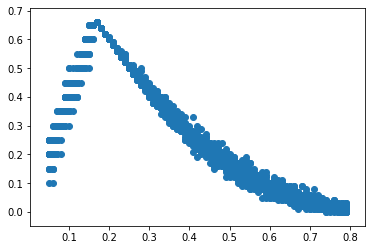

In [50]:
import matplotlib.pyplot as plt
set(density_list)
avg_flow_rate_list = [np.mean(flow_rate_list[x:x+20]) for x in range(0, len(flow_rate_list), 20)]

plt.scatter(density_list,flow_rate_list)
#plt.plot(density_list,flow_rate_list)
plt.show()

In [25]:
class TrafficSimulationMultiLane(TrafficSimulation):
    def __init__(self, road_length, traffic_density, max_velocity, slowdown_proba, 
                 p_swap_lane = 1, n_lanes=2, look_ahead=5):
        super().__init__(road_length, traffic_density, max_velocity, slowdown_proba)
        
        assert type(n_lanes)==int, "Number of lanes must be an integer"
        assert n_lanes > 1, "Multilane traffic simulation must have atleast 2 lanes"
        self.n_lanes = 2
        
        assert type(n_lanes)==int, "Number of lanes must be an integer"
        self.look_ahead = look_ahead
        
        self.look_back = max_velocity
        
        #Make road
        #Infer number of cars
        self.num_cars = np.round(road_length*traffic_density*n_lanes)
        num_cars = np.round(road_length*traffic_density)
        road_array = np.full((n_lanes, road_length), -1)
        
        car_counter = 0
        #Insert the cars with 0 velocity at random positions on the road
        while car_counter < num_cars:
            random_loc = random.randrange(0, n_lanes), random.randrange(0, road_length)
            if road_array[random_loc] == -1:
                road_array[random_loc] = 0
                car_counter += 1
                
        self.road = road_array
        
    def look(lane, cell, ahead=True):
        '''
        Takes a current position, defined using lane and cell
        Returns distance to next car in direction ahead
        if ahead=False, returns distance to next car behind
        '''
        #1 if ahead
        if ahead:
            increment = 1
        else: 
            increment = -1
            
        distance = increment  # The number of empty cells between this car and the next plus 1
        while self.road[lane, (cell + distance) % self.length] == -1:
            distance += increment
        
        return distance
        
    def can_accelerate(velocity, front_distance):
        '''
        Takes a speed and a distance to the next car in front,
        return a bool indicating if the car can speed up 
        (or in the case it is already at max_velocity, maintain its speed)
        '''
        
        #If already at max speed, see if you can maintain it in lane
        if velocity == self.max_velocity:
            if velocity >= front_distance:
                return False
        
        else: #see if you can speed up
            if velocity+1 >= front_distance:
                return False
        
        return True
    
    def check_lane(lane, position, velocity, current_lane=False):
        '''
        Checks if car, moved to road[lane, position] can:
        1) Accelerate
        2) Fit without obstructing car behind it
        '''
        
        #Look ahead, see if can accelerate
        front_distance = self.look(position, ahead=True)
        if not self.can_accelerate(velocity, front_distance):
            return False
        
        #Look back, see if there is space
        back_distance = self.look(position, ahead=False)
        if back_distance < self.max_velocity:
            return False
        
        return True
        
    def update_lanes(self):
        '''
        Updates the lane of each of the cars on the road,
        Starting from the top lane and working downwards
        '''
        #Make an empty road to store updates on
        next_state = np.full((self.n_lanes, self.road_length), -1)
        
        for lane in range(self.n_lanes):
            #For every cell in lane
            for cell in self.road[lane, :]:                
                
                #Current speed of car
                current_velocity = self.road[lane, cell]
                
                #Get distance to car in front
                distance = self.look(self.road[lane, cell])
                
                #Flag for whether the car will look for lane swap
                attempt_lane_swap = not self.can_accelerate(current_velocity, distance)
                    
                #Try switching to lane above, else try lane down
                if attempt_lane_swap:
                    
                    #If not already in the top lane, evaluate switching there
                    if lane-1 > 0:
                        if check_lane(lane-1, car, current_velocity, current_velocity==self.max_velocity):
                            
                            #Swap possible to swap, swap with p=p_swap_lane
                            if random.random() <= p_swap_lane:
                                next_state[lane-1, car] = current_velocity  
                                
                    #If not already in the bottom lane, evaluate switching there
                    #Same logic applies
                    elif lane+1 <= self.n_lanes:
                        if self.check_lane(lane+1, position, current_velocity):
                            
                            #Swap possible to swap, swap with p=p_swap_lane
                            if random.random() <= p_swap_lane:
                                next_state[lane+1, car] = current_velocity
                                
                        
    def run(self, steps, warmup=25, display=False, track=True):
        '''
        Runs warmup laps without visualizing the results to get cars up to speed
        Then visualizes steps of the simulation
        '''
        
        #Warmup: Run warmup times without displaying state
        for step in range(warmup):

            #Update lanes, velocities and step
            self.update_lanes()
            self.update_velocities()
            self.step()

        #Run simulation for # steps, displaying state after each
        for step in range(steps):
            #Display state
            if display:
                self.display()

            #Update and step
            self.update_lanes()
            self.update_velocities()
            self.step()
            

In [26]:
my_road = TrafficSimulationMultiLane(100, 0.5, 5, 0.5)
my_road.run(20)

NameError: name 'self' is not defined

In [75]:
a = np.array((np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1]), np.array([ 2,  4,  5,  8, 14, 20, 31, 33, 34, 36, 39, 41, 44, 46, 49, 54, 55,
       59, 61, 65, 69, 74, 81, 85, 87, 99,  3,  7, 10, 13, 22, 25, 30, 33,
       37, 38, 42, 49, 55, 56, 57, 69, 72, 75, 76, 82, 85, 87, 92, 94])))

a[0, :]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [11]:
ahead = False
ahead*(-1*ahead)

0